**To test on the boundary boxes**
- Group the boxes into 1 for example digit 78834 have 5 boxes combined into 1
- Filter and remove non digits detection

In [1]:
import numpy as np
import scipy as sp
from PIL import Image #pip install Pillow
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import pickle
import cv2

In [3]:

# Load the model from the file
model_path = 'models/cnn_model.pkl'
with open(model_path, 'rb') as file:
    model1 = pickle.load(file)

input_shape = (28, 28, 1)
print('Load complete...')

Load complete...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


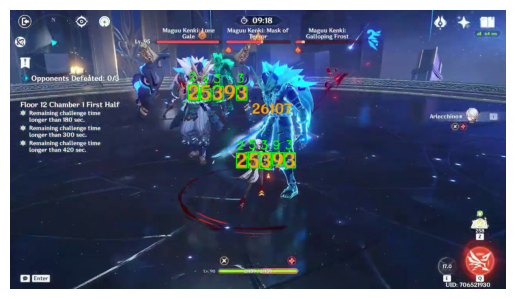

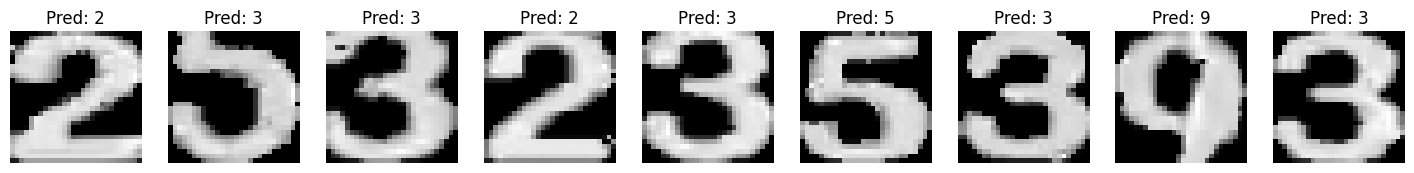

Recognized Number: 233235393


In [11]:


import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = 'img/train/frame45.jpg'
image = cv2.imread(image_path)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_orange = np.array([10, 110, 110])  # Start of orange hue
upper_orange = np.array([25, 255, 255])  # End of orange hue

# lower_orange = np.array([10, 100, 100]) 
# upper_orange = np.array([25, 255, 255])



orange_mask = cv2.inRange(hsv_image, lower_orange, upper_orange)
orange_only = cv2.bitwise_and(image, image, mask=orange_mask)

gray_orange_only = cv2.cvtColor(orange_only, cv2.COLOR_BGR2GRAY)

thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]




#=======================================================================================================================
# Invert the black and white (now digits will be black on white background)
inverted_thresh = cv2.bitwise_not(thresh)


#=======================================================================================================================
# apply an "opening" morphological operation to disconnect components

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
opening = cv2.morphologyEx(inverted_thresh, cv2.MORPH_OPEN, kernel)


#=======================================================================================================================
# Detect contours in the thresholded image (to focus on digit areas)
contours,_= cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

digit_images = []
areaContour = []
predictions = []
recognized_digits = ""

x_min, y_min = float('inf'), float('inf')
x_max, y_max = 0, 0

sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

for contour in sorted_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if h > 10 and w > 5: 

        aspect_ratio = w / h
        area = cv2.contourArea(contour)

        if 0.2 < aspect_ratio < 1.0:

            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)
            
            if area > 300:

                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                cropped_img = gray_orange_only[y:y + h, x:x + w]
                ROI = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                resized_img = cv2.resize(cropped_img, (28, 28))
                normalized_img = resized_img / 255.0
                img_array = np.expand_dims(normalized_img, axis=(0, -1))
                prediction = model1.predict(img_array)
                predictions.append(np.argmax(prediction, axis=1)[0])

                recognized_digit = np.argmax(prediction, axis=1)[0]
                recognized_digits += str(recognized_digit)

                digit_images.append(normalized_img)
                areaContour.append(area)

                cv2.putText(image, str(recognized_digit), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the modified image with the combined bounding box
#cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3) 
#cv2.putText(image, recognized_digits, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

num_digits = len(digit_images)
if num_digits > 0:
    fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))

    for i, ax in enumerate(axes[:num_digits]):
        ax.imshow(digit_images[i], cmap='gray')
        ax.set_title(f'Pred: {predictions[i]}')
        ax.axis('off')  

    plt.show() 
else:
    print("No digit images found to display.")


print("Recognized Number:", recognized_digits)


In [28]:
def classify_cut(cut, model=model1):
    sample = cv2.resize(cut, (28, 28))
    normalized_img = sample / 255.0

    img_array = np.expand_dims(normalized_img, axis=(0, -1))
  
    pred = model.predict(img_array)
    label = pred.argmax(axis=1)[0]
    p = np.max(pred)
    
    return label, p

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image_with_orange_detection(image_path,model1):

    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    
    orange_mask = cv2.inRange(hsv_img, lower_orange, upper_orange)
    orange_regions = cv2.bitwise_and(img, img, mask=orange_mask)
    
    gray_orange_only = cv2.cvtColor(orange_regions, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to detect digits
    _, thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    inverted_thresh = cv2.bitwise_not(thresh)

    # apply an "opening" morphological operation to disconnect components
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
    opening = cv2.morphologyEx(inverted_thresh, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    digit_images = []

    # Loop through each contour and detect likely digit areas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        if h > 10 and w > 5:  
            # Crop the detected region based on contour
            cropped_img = gray_orange_only[y:y + h, x:x + w]
            
            label, p = classify_cut(cropped_img, model=model1)
            
            if label != 10 and p > 0.98:
                # Store box details and append to list
                box = {
                    'x': x, 'y': y,
                    'w': w, 'h': h,
                    'label': label,
                    'p': p
                }
                boxes.append(box)
                
                # Print the box details with label and confidence
                print(f"Box: [x: {x}, y: {y}, w: {w}, h: {h}], Label: {label}, Confidence: {p:.2f}")
                
                # Add the cut region to digit_images for further processing or storage
                digit_images.append(resized_img)
    
    return digit_images, boxes


In [41]:
image_path = 'img/train/frame50.jpg'  

# Preprocess the image and detect digits
digit_images, boxes = preprocess_image_with_orange_detection(image_path,model1)

boxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[]

In [ ]:
image_path = 'img/train/frame50.jpg'  

# Preprocess the image and detect digits
digit_images, predictions = preprocess_image_with_orange_detection(image_path,model1)

# Plot the detected digits and their predictions in a grid
num_digits = len(digit_images)

# Set up a grid for subplots (1 row, multiple columns based on the number of digits)
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))  # Adjust the size as necessary

for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap='gray')
    ax.set_title(f'Pred: {predictions[i]}')
    ax.axis('off')  # Hide the axes for clarity

plt.tight_layout()
plt.show()